# Interactions or not

Let's say you have two categorical variables. Want to get effect of one on another. 
- interaction or additive
- interaction model has some advantages. you can get the slopes in additive model from interaction model. it's in the contrasts.

Rojan: the interaction model would answer what is the probability of getting admission for each departments for each gender,
whereas non interaction model would answer what is the probability of getting admission for each gender averaged across all the departments

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
from scipy.special import logit
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Data and DAG

In [4]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_ucb = pd.read_csv(DATA_DIR + "UCBadmit.csv", sep=";", header=0)
# Encode categorical variables
df_ucb["dept_code"] = pd.Categorical(df_ucb["dept"]).codes
df_ucb["gender_code"] = pd.Categorical(df_ucb["applicant.gender"]).codes

# Numbers of unique variables for use later
n_gid = len(df_ucb['gender_code'].unique())
n_dept = len(df_ucb['dept_code'].unique())
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


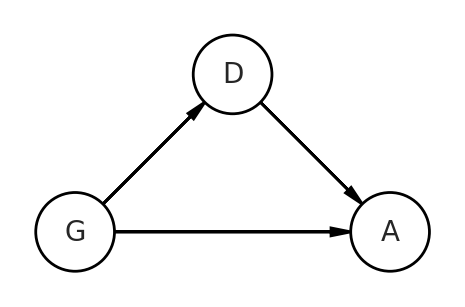

<IPython.core.display.Javascript object>

In [5]:
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "D": (1, 1),
    "G": (0, 0),
    "A": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

In [39]:
# write model
with pm.Model() as m0m:
    # Hyperpriors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    sigma = pm.HalfNormal("sigma", 0.1)

    # Priors
    a = pm.Normal("a", mu=a_bar, sd=sigma, shape=2)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_code"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_m0m = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.


<IPython.core.display.Javascript object>

In [ ]:
az.summary(idata_m0m)

# Conditioning variable as additive term

Rojan:
> what is the probability of getting admission for each gender averaged across all the departments

McEleath
> Instead of asking “What are the average probabilities of admission for women and men across all departments?” we want to ask “What is the average difference in probability of admission between women and men within departments?” In order to ask the second question, we estimate unique female and male admission rates in each department.

We'll be doing this with two models, one fixed effects and one with a varying effects model. The likelihood and logit link functions are the same for both:

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{GID}[i]} + \delta_{\text{DEPT}[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) \tag{prior for gender} $$
$$ \delta_k \sim \text{Normal}(0, 1.5) \tag{prior for department} $$

In [15]:
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

In [17]:
# book example, pg 343)
with pm.Model() as m1f:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=n_gid)
    d = pm.Normal("d", mu=0, sd=1, shape=n_dept)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_code"]] + d[df_ucb["dept_code"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_m1f = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.8961596107233745, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [24]:
az.summary(idata_m1f, var_names=["a", "d"])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.440,0.355,-1.013,0.109,0.007,0.005,2440.0,2158.0,2444.0,2373.0,1.0
a[1],-0.534,0.355,-1.090,0.027,0.007,0.005,2409.0,2139.0,2414.0,2365.0,1.0
d[0],1.113,0.359,0.533,1.668,0.007,0.005,2447.0,2277.0,2452.0,2475.0,1.0
d[1],1.066,0.363,0.505,1.653,0.007,0.005,2498.0,2360.0,2501.0,2558.0,1.0
d[2],-0.142,0.359,-0.727,0.408,0.007,0.005,2469.0,2415.0,2474.0,2358.0,1.0
d[3],-0.176,0.358,-0.761,0.371,0.007,0.005,2468.0,2468.0,2472.0,2374.0,1.0
d[4],-0.616,0.362,-1.188,-0.039,0.007,0.005,2531.0,2531.0,2531.0,2658.0,1.0
d[5],-2.147,0.375,-2.727,-1.536,0.007,0.005,2680.0,2680.0,2679.0,2971.0,1.0


<IPython.core.display.Javascript object>

In [29]:
with pm.Model() as m1ma:

    # Hyperpriors
    a_bar = pm.Normal("a_bar", mu=0, sd=1, shape=n_gid)
    sigma_a = pm.HalfNormal("sigma_a", 0.1)

    d_bar = pm.Normal("d_bar", mu=0, sd=1, shape=n_dept)
    sigma_d = pm.HalfNormal("sigma_d", 0.1)

    # Adaptive priors
    a = pm.Normal("a", mu=a_bar, sd=sigma_a, shape=n_gid)
    d = pm.Normal("d", mu=d_bar, sd=sigma_d, shape=n_dept)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_code"]] + d[df_ucb["dept_code"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_m1ma = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a, sigma_d, d_bar, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 122 seconds.
There were 379 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786258789998698, but should be close to 0.95. Try to increase the number of tuning steps.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9044711648010288, but should be close to 0.95. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

Deal with divergences later.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Ma

Text(0.5, 1.0, 'gender and department (multilevel')

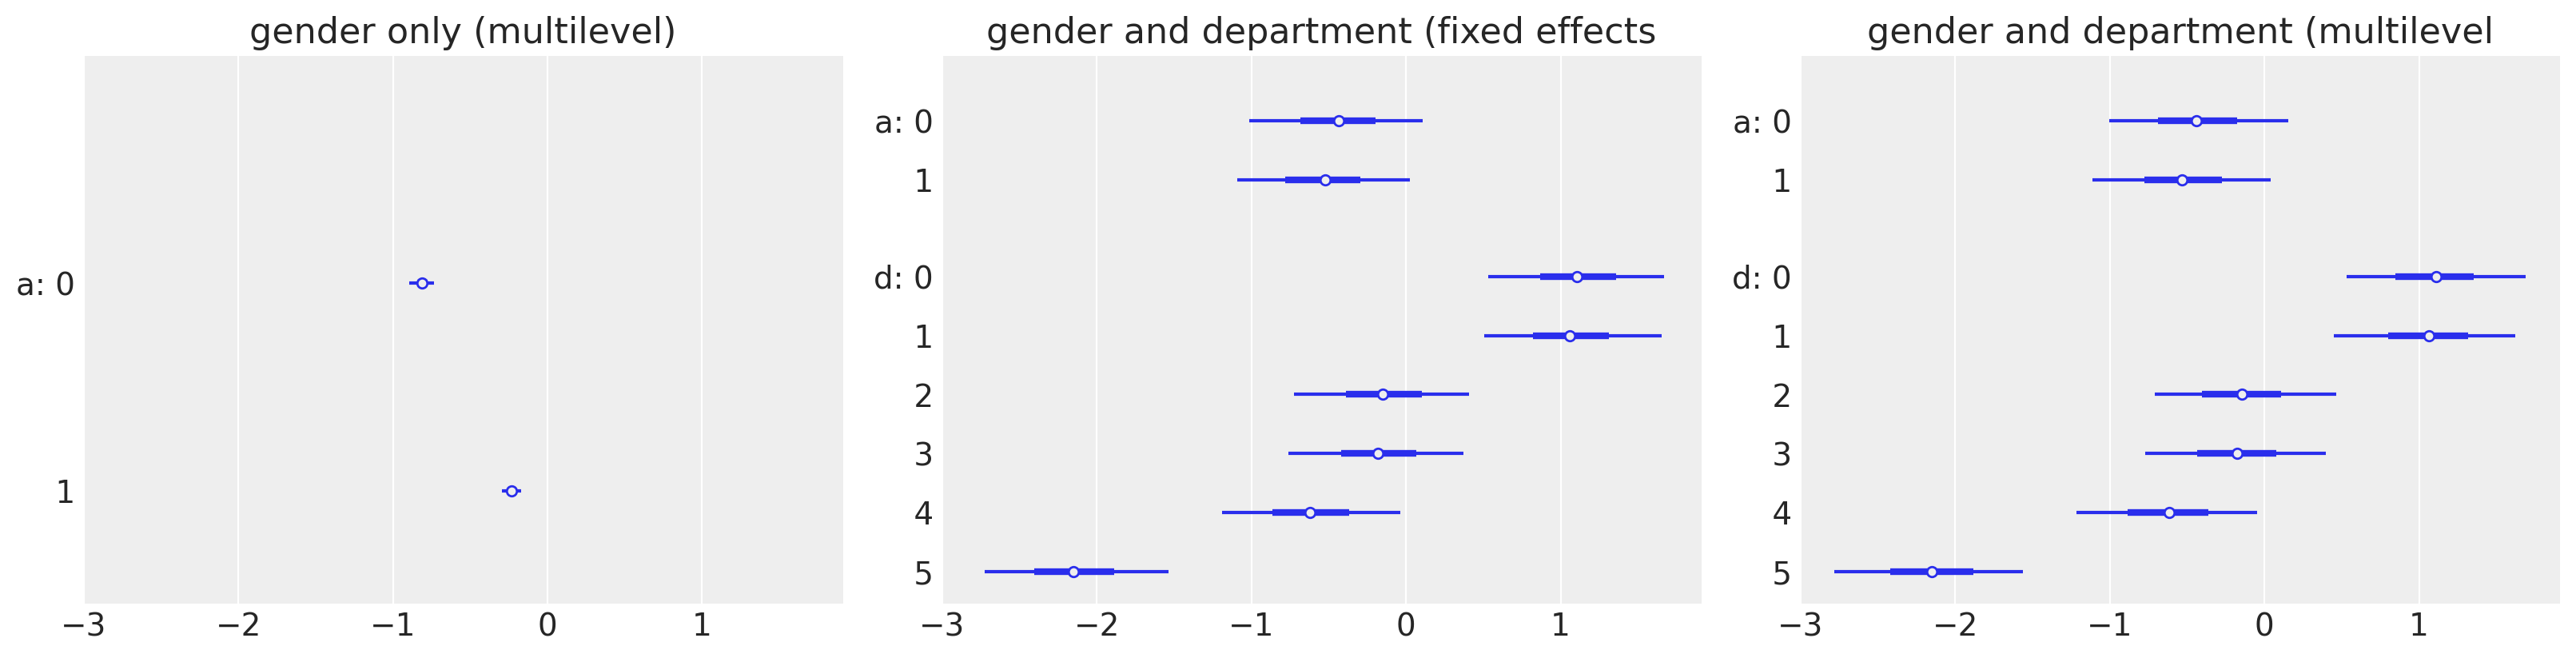

<IPython.core.display.Javascript object>

In [44]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
az.plot_forest(idata_m0m, combined=True, var_names=["a"], ax=ax1)
az.plot_forest(idata_m1f, combined=True, var_names=["a", "d"], ax=ax2)
az.plot_forest(idata_m1ma, combined=True, var_names=["a", "d"], ax=ax3)

ax1.set_title('gender only (multilevel)')
ax2.set_title('gender and department (fixed effects')
ax3.set_title('gender and department (multilevel')

### Correlated effects

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{GID}[i]} + \delta_{\text{DEPT}[i]} $$
$$\begin{bmatrix}\alpha_{\text{GID}} \\ \delta_{\text{DEPT}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix} \bar{\alpha} \\ \bar{\delta} \end{bmatrix} , \textbf{S} \right)  \tag{population of varying effects} $$

In [ ]:
with pm.Model() as m1mb:

    # Hyperpriors
    sd_dist = pm.Exponential.dist(1.0)
    chol_dist, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

        # adaptive priors?
    a = pm.Normal("a", mu=0, sd=1.5)  # used same from previous problem
    b = pm.Normal("b", mu=0, sd=2)  # use something conservative

    ab_district = pm.MvNormal(
        "ab_district", mu=tt.stack([a, b]), chol=chol, shape=(N_districts, 2)
    )  # population of varying effects
    # shape needs to be (N_districts, 2) because we're getting back both a and b for each district


    # Adaptive priors
    a = pm.Normal("a", mu=a_bar, sd=sigma_a, shape=n_gid)
    d = pm.Normal("d", mu=d_bar, sd=sigma_d, shape=n_dept)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_code"]] + d[df_ucb["dept_code"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_m1ma = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

In [ ]:
# code modified from repo and adapted for binomial likelihood
# this takes ~4 min to run

with pm.Model() as mq3a:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    # adaptive priors?
    a = pm.Normal("a", mu=0, sd=1.5)  # used same from previous problem
    b = pm.Normal("b", mu=0, sd=2)  # use something conservative

    ab_district = pm.MvNormal(
        "ab_district", mu=tt.stack([a, b]), chol=chol, shape=(N_districts, 2)
    )  # population of varying effects
    # shape needs to be (N_districts, 2) because we're getting back both a and b for each district

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_district[df_bangladesh["district_code"], 0]
            + ab_district[df_bangladesh["district_code"], 1] * df_bangladesh["urban"]
        ),
    )

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq3a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

In [ ]:
# alternate code, better adaptation to lecture (centered model)
# similar to book code

idx_dist = df_bangladesh["district_code"]
idx_urban = df_bangladesh["urban"]

with pm.Model() as mq3a1:

    # fixed priors                     ---------- 
    tau_A = pm.Exponential("tau_A", 1)                             # standard deviation for each district
    a_bar = pm.Normal("a_bar", mu=0.0, sd=tau_A, shape=N_districts)    # average district mean
    # correlation matrix prior
        # LKJCholeskyCov is more efficient than LKJCorr
        # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    sd_dist = pm.Exponential.dist(1.0)
    chol_dist, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    # adaptive prior                   ----------
    alpha = pm.MvNormal("alpha", mu=0.0, chol=chol_dist, shape=(N_districts, N_urban)) 

    # link function                    ---------- 
    p = pm.Deterministic("p", pm.math.invlogit(a_bar[idx_dist] + alpha[idx_dist, idx_urban]))

    # likelihood                       ----------
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq3a1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

# Conditioning variable as interactive term

Rojan says interaction is like pandas groupby

In [32]:
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

In [37]:
df_ucb['admit'] / df_ucb['applications']

1     0.620606
2     0.824074
3     0.630357
4     0.680000
5     0.369231
6     0.340641
7     0.330935
8     0.349333
9     0.277487
10    0.239186
11    0.058981
12    0.070381
dtype: float64

<IPython.core.display.Javascript object>

## Fixed effects

## Mixed effects

# Getting information of additive term from interaction model

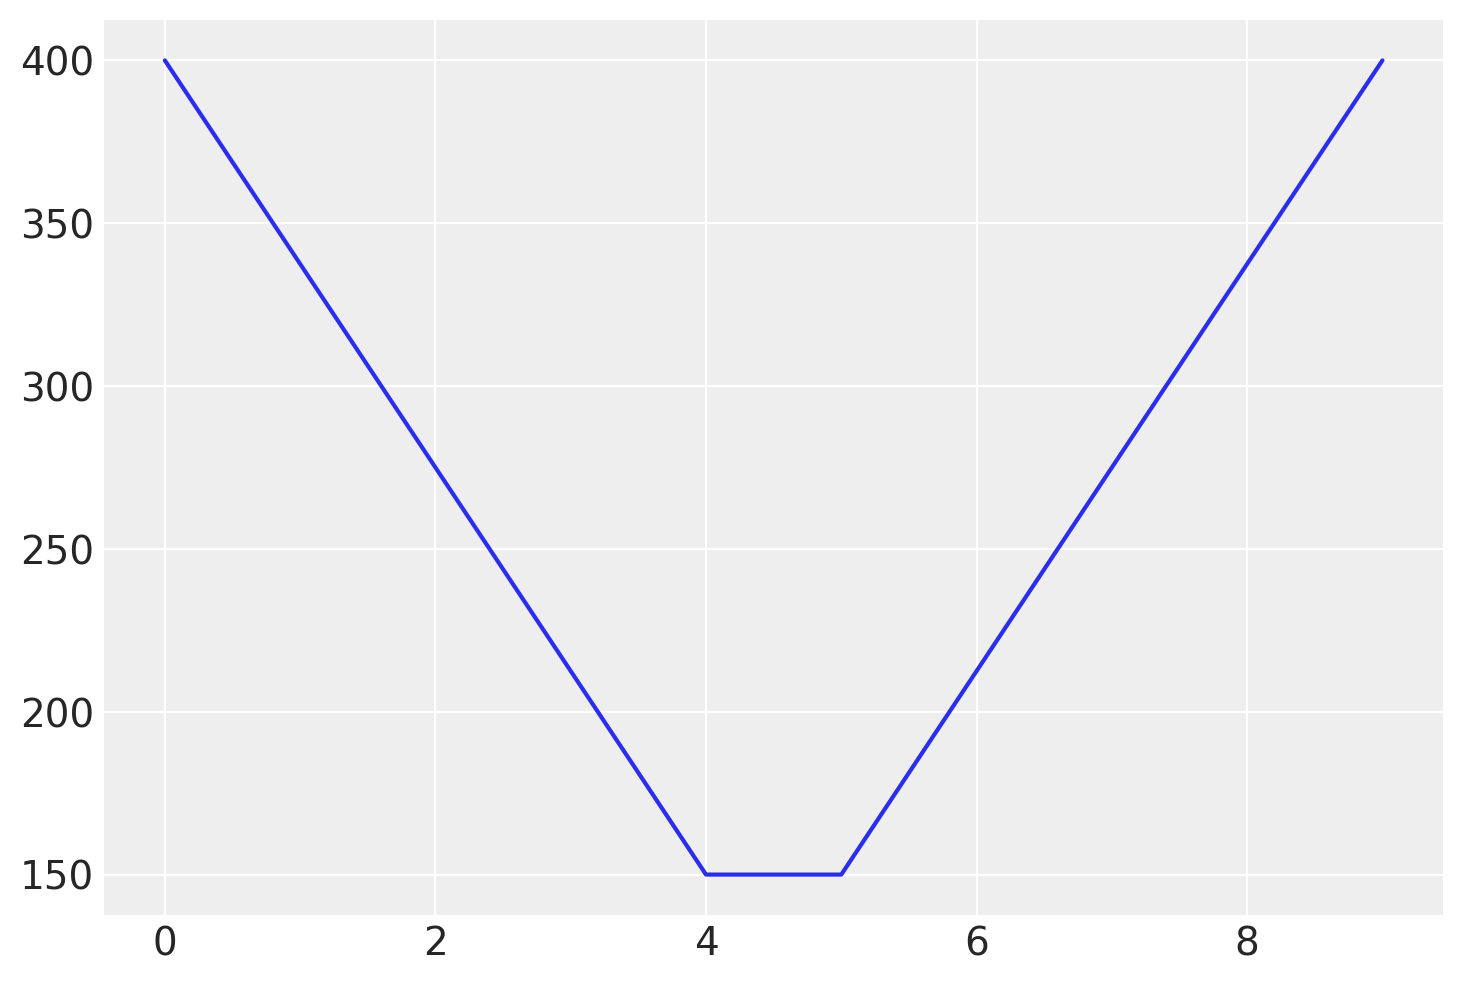

<IPython.core.display.Javascript object>

In [24]:
plt.plot(df_trend['day'], df_trend['ANC'])

In [ ]:
anc = 

In [21]:
list(np.linspace(400, 150, 5)) + list(np.linspace(150, 400, 5))

[400.0, 337.5, 275.0, 212.5, 150.0, 150.0, 212.5, 275.0, 337.5, 400.0]

<IPython.core.display.Javascript object>

# Q1

The data in `data(NWOGrants)` are outcomes for scientific funding applications
for the Netherlands Organization for Scientific Research (NWO) from 2010–2012
(see van der Lee and Ellemers doi:10.1073/pnas.1510159112). These data have a
very similar structure to the UCBAdmit data discussed in Chapter 11. Draw a DAG
for this sample and then use one or more binomial GLMs to estimate the TOTAL
causal effect of gender on grant awards.

## Answer

The DAG from Chapter 11 can essentially be re-used since the `discipline` field can be used instead of `department` and `award` instead of `admit`.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


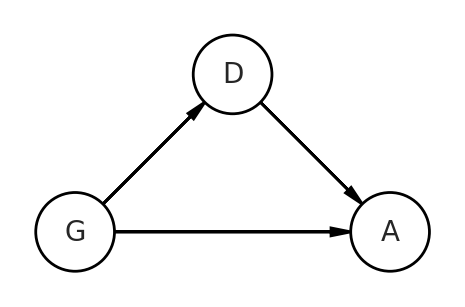

<IPython.core.display.Javascript object>

In [ ]:
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "D": (1, 1),
    "G": (0, 0),
    "A": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

### Replicate UCB data

In [22]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
# df_grants = pd.read_csv(DATA_DIR + "NWOGrants.csv", sep=";", header=0)
df_grants = pd.read_csv(DATA_DIR + "UCBadmit.csv", sep=";", header=0)
df_grants.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


<IPython.core.display.Javascript object>

Therefore, to get the total causal effect, we simply include gender in the model and not stratify by department (or discipline in the award data).


$$ A \sim \text{Binomial}(n_{i}, p_{i}) $$
$$ \text{logit}(p) = \alpha_{GID}$$
$$ \alpha_{j} \sim \text{Normal}(0, 1.5) $$


In [25]:
# index encode variables
df_grants['gender_ind'] = pd.Categorical(df_grants['applicant.gender'], categories=["male", "female"]).codes
df_grants['dept_ind'] = pd.Categorical(df_grants['dept']).codes

<IPython.core.display.Javascript object>

In [26]:
df_grants.head()

,dept,applicant.gender,admit,reject,applications,gender_ind,dept_ind
1,A,male,512,313,825,0,0
2,A,female,89,19,108,1,0
3,B,male,353,207,560,0,1
4,B,female,17,8,25,1,1
5,C,male,120,205,325,0,2


<IPython.core.display.Javascript object>

In [27]:
# write model
with pm.Model() as mq1:

    # Priors
    a = pm.Normal("a", mu=0, sd=1.5, shape=2)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_ind"]]))

    # likelihood
    award = pm.Binomial("award", n=df_grants['applications'], p=p, observed=df_grants['admit'])

    # generate posterior and sample
    idata_mq1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [28]:
az.summary(idata_mq1, var_names='a')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.221,0.039,-0.281,-0.159,0.001,0.000,3442.0,3436.0,3436.0,3051.0,1.0
a[1],-0.830,0.049,-0.912,-0.756,0.001,0.001,3426.0,3426.0,3432.0,2936.0,1.0


<IPython.core.display.Javascript object>

### Grant awards

In [30]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_grants = pd.read_csv(DATA_DIR + "NWOGrants.csv", sep=";", header=0)
df_grants.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


<IPython.core.display.Javascript object>

In [461]:
# index encode variables
df_grants['gender_ind'] = pd.Categorical(df_grants['gender'], categories=["m", "f"]).codes
df_grants['discipline_ind'] = pd.Categorical(df_grants['discipline']).codes

<IPython.core.display.Javascript object>

In [36]:
# write model
with pm.Model() as mq1b:

    # Priors
    a = pm.Normal("a", mu=0, sd=1.5, shape=2)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_ind"]]))

    # likelihood
    award = pm.Binomial("award", n=df_grants['applications'], p=p, observed=df_grants['awards'])

    # generate posterior and sample
    idata_mq1b = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

In [38]:
az.summary(idata_mq1b, var_names='a')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.535,0.066,-1.638,-1.431,0.001,0.001,3693.0,3664.0,3708.0,2773.0,1.0
a[1],-1.736,0.083,-1.875,-1.612,0.001,0.001,3616.0,3616.0,3611.0,2649.0,1.0


<IPython.core.display.Javascript object>

Look more at [what I did last year](https://github.com/benslack19/stats_rethinking/blob/main/SR_notebooks_2021/stats_rethinking_ch11_hw06.ipynb).

In [237]:
idata_mq1b_df = idata_mq1b.to_dataframe()
idata_mq1b_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, p[0], 0)","(posterior, p[10], 10)","(posterior, p[11], 11)","(posterior, p[12], 12)","(posterior, p[13], 13)","(posterior, p[14], 14)",...,"(sample_stats, step_size_bar)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, energy_error)","(sample_stats, process_time_diff)","(sample_stats, perf_counter_start)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, step_size)"
0,0,0,-1.557060,-1.726432,0.174069,0.174069,0.151045,0.174069,0.151045,0.174069,...,1.218064,65.108397,-65.057294,0.016140,0.000457,468.251165,0.978434,False,0.028087,1.142159
1,0,1,-1.557060,-1.726432,0.174069,0.174069,0.151045,0.174069,0.151045,0.174069,...,1.218064,65.582284,-65.057294,0.000000,0.000214,468.251724,0.742179,False,0.298165,1.142159
2,0,2,-1.519500,-1.753968,0.179535,0.179535,0.147547,0.179535,0.147547,0.179535,...,1.218064,65.078283,-65.007525,-0.019402,0.000468,468.252107,0.999606,False,-0.019402,1.142159
3,0,3,-1.509418,-1.780629,0.181025,0.181025,0.144226,0.181025,0.144226,0.181025,...,1.218064,65.171804,-65.168094,0.055607,0.000262,468.252713,0.945911,False,0.055607,1.142159
4,0,4,-1.548327,-1.734039,0.175328,0.175328,0.150072,0.175328,0.150072,0.175328,...,1.218064,65.250460,-65.004794,-0.058119,0.000457,468.253073,0.982631,False,-0.058119,1.142159


<IPython.core.display.Javascript object>

In [238]:
idata_mq1b_df.columns

Index([                               'chain',
                                       'draw',
                     ('posterior', 'a[0]', 0),
                     ('posterior', 'a[1]', 1),
                     ('posterior', 'p[0]', 0),
                   ('posterior', 'p[10]', 10),
                   ('posterior', 'p[11]', 11),
                   ('posterior', 'p[12]', 12),
                   ('posterior', 'p[13]', 13),
                   ('posterior', 'p[14]', 14),
                   ('posterior', 'p[15]', 15),
                   ('posterior', 'p[16]', 16),
                   ('posterior', 'p[17]', 17),
                     ('posterior', 'p[1]', 1),
                     ('posterior', 'p[2]', 2),
                     ('posterior', 'p[3]', 3),
                     ('posterior', 'p[4]', 4),
                     ('posterior', 'p[5]', 5),
                     ('posterior', 'p[6]', 6),
                     ('posterior', 'p[7]', 7),
                     ('posterior', 'p[8]', 8),
             

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'difference'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'Gender diff (F-M)')]

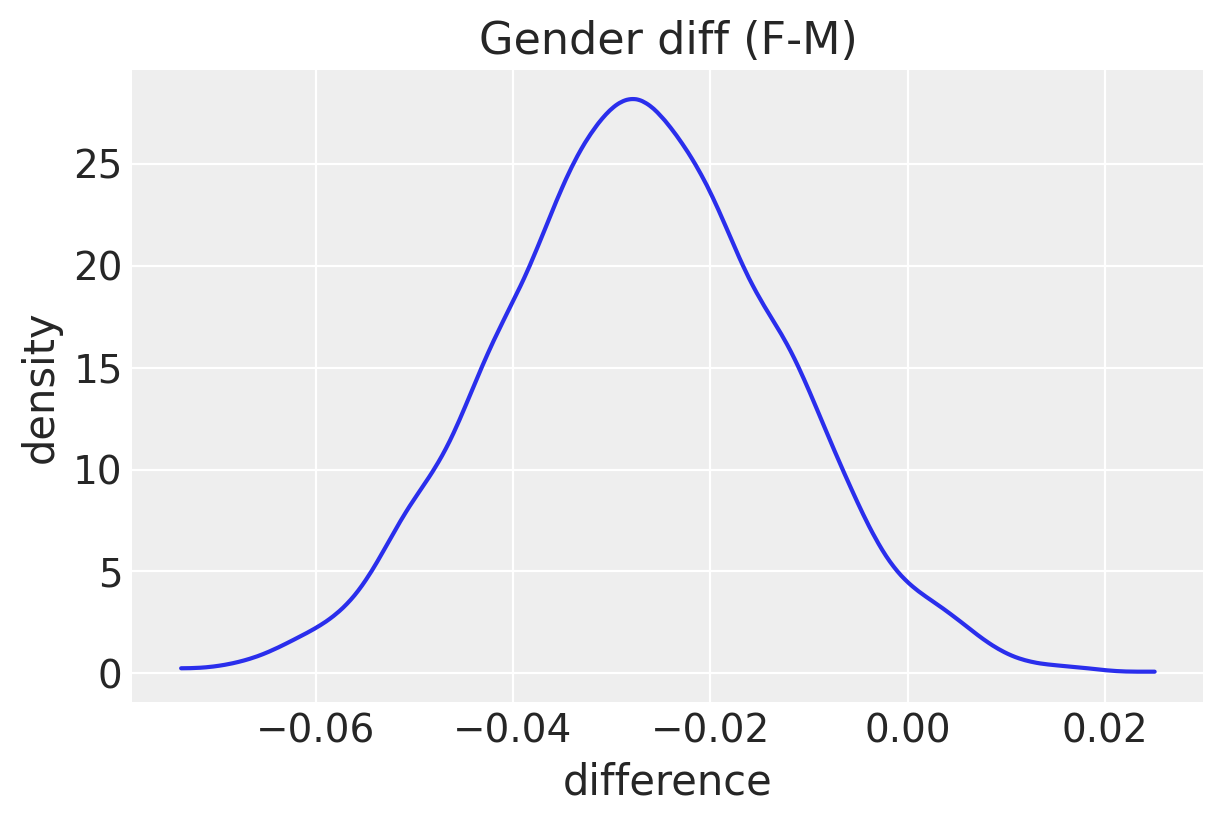

<IPython.core.display.Javascript object>

In [312]:
f, ax1 = plt.subplots(figsize=(6, 4))
# sns.kdeplot(idata_mq1b_df[('posterior', 'a[1]', 1)] - idata_mq1b_df[('posterior', 'a[0]', 0)])
az.plot_kde(expit(idata_mq1b_df[('posterior', 'a[1]', 1)] )- expit(idata_mq1b_df[('posterior', 'a[0]', 0)]), ax=ax1)
ax1.set(xlabel='difference', ylabel='density', title='Gender diff (F-M)')

# Q2

Now estimate the DIRECT causal effect of gender on grant awards. Compute the average direct causal effect of gender, weighting each discipline in proportion to the number of applications in the sample. Refer to the marginal effect example in Lecture 9 for help.

## Answer


### UCB example

In [389]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_ucb = pd.read_csv(DATA_DIR + "UCBadmit.csv", sep=";", header=0).reset_index(drop=True)
df_ucb.head()

,dept,applicant.gender,admit,reject,applications
0,A,male,512,313,825
1,A,female,89,19,108
2,B,male,353,207,560
3,B,female,17,8,25
4,C,male,120,205,325


<IPython.core.display.Javascript object>

In [390]:
[print(i) for i in sorted(os.listdir(DATA_DIR)) if 'UCB' in i ]

UCBadmit.csv


[None]

<IPython.core.display.Javascript object>

In [391]:
# index encode variables
df_ucb['gender_ind'] = pd.Categorical(df_ucb['applicant.gender'], categories=["female", "male"]).codes
df_ucb['dept_ind'] = pd.Categorical(df_ucb['dept']).codes

n_dept = len(df_ucb['dept_ind'].unique())

<IPython.core.display.Javascript object>

#### Linear model way (like book, pg 343)

In [435]:
# model without weighting
with pm.Model() as mq2_book:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=2)
    b = pm.Normal("b", mu=0, sd=1, shape=n_dept)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_ind"]] + b[df_ucb["dept_ind"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_mq2_book = pm.sample(draws=5000, tune=1000, return_inferencedata=True, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [441]:
az.summary(idata_mq2_book, var_names=['a', 'b'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.433,0.360,-1.013,0.138,0.008,0.006,1894.0,1894.0,1905.0,1835.0,1.0
a[1],-0.526,0.358,-1.085,0.057,0.008,0.006,1897.0,1897.0,1907.0,1845.0,1.0
b[0],1.104,0.363,0.557,1.709,0.008,0.006,1952.0,1952.0,1962.0,1945.0,1.0
b[1],1.059,0.365,0.472,1.626,0.008,0.006,1969.0,1969.0,1982.0,2083.0,1.0
b[2],-0.151,0.363,-0.742,0.416,0.008,0.007,1925.0,1485.0,1936.0,1909.0,1.0
b[3],-0.184,0.363,-0.764,0.391,0.008,0.007,1921.0,1533.0,1927.0,1956.0,1.0
b[4],-0.623,0.367,-1.215,-0.044,0.008,0.006,2008.0,1751.0,2021.0,2015.0,1.0
b[5],-2.157,0.381,-2.775,-1.561,0.008,0.006,2074.0,1997.0,2085.0,2212.0,1.0


<IPython.core.display.Javascript object>

Above answers are consistent with the book (gender order flipped).

#### Matrix way (like 2022 lecture 9)

In [437]:
# model without weighting

gi = df_ucb["gender_ind"]
di = df_ucb["dept_ind"]

with pm.Model() as mq2_lec:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=(2, n_dept))

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[gi, di]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_mq2_lec = pm.sample(draws=5000, tune=1000, return_inferencedata=True, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.


<IPython.core.display.Javascript object>

In [438]:
az.summary(idata_mq2_lec)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",1.471,0.244,1.094,1.872,0.002,0.001,25917.0,23621.0,26510.0,14245.0,1.0
"a[0,1]",0.662,0.399,0.014,1.293,0.002,0.002,29035.0,19732.0,29298.0,13479.0,1.0
"a[0,2]",-0.657,0.087,-0.791,-0.515,0.001,0.000,28854.0,27695.0,28936.0,12892.0,1.0
"a[0,3]",-0.615,0.109,-0.789,-0.443,0.001,0.000,28374.0,26923.0,28379.0,14892.0,1.0
"a[0,4]",-1.146,0.116,-1.324,-0.953,0.001,0.000,35361.0,34127.0,35497.0,15063.0,1.0
"a[0,5]",-2.491,0.200,-2.806,-2.171,0.001,0.001,25686.0,24906.0,26078.0,15265.0,1.0
"a[1,0]",0.490,0.071,0.372,0.600,0.000,0.000,32550.0,32003.0,32533.0,15057.0,1.0
"a[1,1]",0.531,0.088,0.392,0.671,0.000,0.000,38747.0,37557.0,38747.0,14596.0,1.0
"a[1,2]",-0.530,0.114,-0.713,-0.349,0.001,0.000,33846.0,30129.0,33983.0,14746.0,1.0
"a[1,3]",-0.699,0.104,-0.867,-0.535,0.001,0.000,26164.0,25493.0,26154.0,16101.0,1.0


<IPython.core.display.Javascript object>

### Why doesn't linear model (book way) get the same answer?

Compare logit transformation below with matrix (lecture) way.

In [439]:
logit(az.summary(idata_mq2_book, var_names='p')['mean'])

p[0]     0.575364
p[1]     0.672220
p[2]     0.532217
p[3]     0.623438
p[4]    -0.676692
p[5]    -0.584055
p[6]    -0.708185
p[7]    -0.614646
p[8]    -1.147205
p[9]    -1.051173
p[10]   -2.666159
p[11]   -2.586689
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [444]:
az.summary(idata_mq2_lec, var_names='a')['mean']

a[0,0]    1.471
a[0,1]    0.662
a[0,2]   -0.657
a[0,3]   -0.615
a[0,4]   -1.146
a[0,5]   -2.491
a[1,0]    0.490
a[1,1]    0.531
a[1,2]   -0.530
a[1,3]   -0.699
a[1,4]   -0.938
a[1,5]   -2.664
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [445]:
expit(az.summary(idata_mq2_lec, var_names='p')['mean'])

p[0]     0.650219
p[1]     0.692110
p[2]     0.652263
p[3]     0.657911
p[4]     0.591701
p[5]     0.584676
p[6]     0.582246
p[7]     0.586860
p[8]     0.570036
p[9]     0.560206
p[10]    0.516494
p[11]    0.519490
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [452]:
idata_mq2_book_df = idata_mq2_book.to_dataframe()

post_diff_ucb_book = dict()
for i in df_ucb.index:
    if i % 2 == 0:
        post_diff_ucb_book[df_ucb.loc[i, 'dept']] = idata_mq2_book_df[('posterior', f'p[{i+1}]', i+1)] - idata_mq2_book_df[('posterior', f'p[{i}]', i)]

<IPython.core.display.Javascript object>

In [449]:
idata_mq2_lec_df = idata_mq2_lec.to_dataframe()

post_diff_ucb_lec = dict()
for i in df_ucb.index:
    if i % 2 == 0:
        post_diff_ucb_lec[df_ucb.loc[i, 'dept']] = idata_mq2_lec_df[('posterior', f'p[{i+1}]', i+1)] - idata_mq2_lec_df[('posterior', f'p[{i}]', i)]

<IPython.core.display.Javascript object>

In [446]:
# # proportion of female from posterior distribution

# f, ax1 = plt.subplots()

# for di in range(6):
#     gi = 0
#     p_f0 = expit(idata_mq2_lec_df[('posterior', f'a[{gi}]', gi)] + idata_mq2_lec_df[('posterior', f'b[{di}]', di)])

#     gi=1
#     p_m0 = expit(idata_mq2_lec_df[('posterior', f'a[{gi}]', gi)] + idata_mq2_lec_df[('posterior', f'b[{di}]', di)])

#     print("di: ", di, (p_m0 - p_f0)[0:5])

#     sns.kdeplot(p_m0 - p_f0, ax=ax1)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'effect of gender by department\nlecture 9 way')

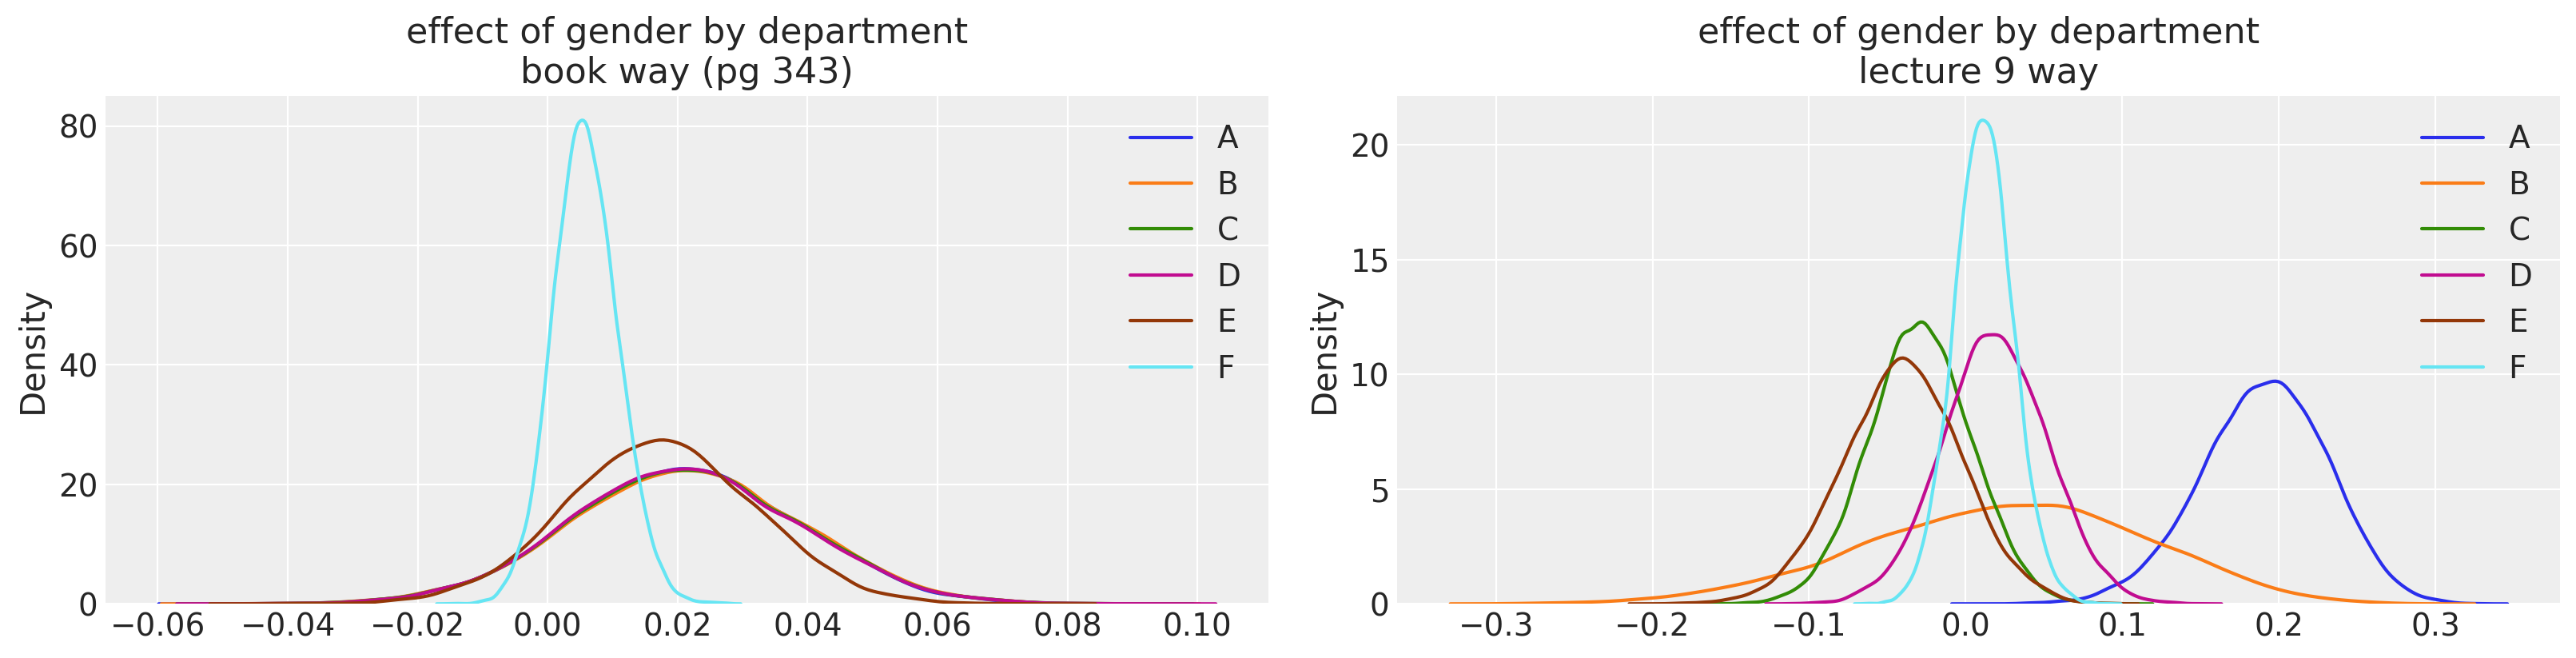

<IPython.core.display.Javascript object>

In [457]:
# same as above by discipline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
for dept in post_diff_ucb_book:
    sns.kdeplot(post_diff_ucb_book[dept], ax=ax1, label=dept)
ax1.legend()
ax1.set_title("effect of gender by department\nbook way (pg 343)")

for dept in post_diff_ucb_lec:
    sns.kdeplot(post_diff_ucb_lec[dept], ax=ax2, label=dept)
ax2.legend()
ax2.set_title("effect of gender by department\nlecture 9 way")

Appendix: Environment and system parameters

In [254]:
%watermark -n -u -v -iv -w

Last updated: Tue Feb 08 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib : 3.3.4
pymc3      : 3.11.0
arviz      : 0.11.1
pandas     : 1.2.1
daft       : 0.1.0
seaborn    : 0.11.1
theano     : 1.1.0
scipy      : 1.6.0
numpy      : 1.20.1
statsmodels: 0.12.2
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]

Watermark: 2.1.0



<IPython.core.display.Javascript object>